In [1]:
"""
Autohr: Sergi Mas Pujol
Last update: 17/11/2020

Python version: 3.6
"""

'\nAutohr: Sergi Mas Pujol\nLast update: 17/11/2020\n\nPython version: 3.6\n'

In [2]:
import numpy as np
np.random.seed(4)
import sys
import math
import random
random.seed(7)
from random import sample
from datetime import datetime, timedelta, date

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7]

from utils_samplesTraining import read_REGULATIONS_file
from utils_timeProcessing import from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots, \
                                 substract_minutes_given_HHSSMM, add_minutes_given_HHSSMM, \
                                 from_YYYYMMDD_to_DDMMYYYY_given_separator, \
                                 listDays_betweenTwoDates, \
                                 from_YYYYMMDDHHMMSS_to_HHMMSS
from utils_samplesTraining import readAssociatedFile_fromAIRAC_givenDate, \
                                  extract_regulations,\
                                  addIntervals_toFinalConjunt, \
                                  compute_start_end_timestamps_from_days_with_regulations, \
                                  convert_to_one_hot
from generator import extract_features_from_list_days_and_timestamps
from utils_trainingModel import WarmUpCosineDecayScheduler

from generator_weather import extract_weather_information_from_list_days_and_timestamps

/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sergi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [3]:
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

from sklearn.model_selection import train_test_split

In [4]:
# sectorName = 'BOLN'
# sectorName = 'B3EH'
# sectorName = 'D6WH'

sectorName = 'HRHR'
# sectorName = 'HSOL'
# sectorName = 'B3LL'

In [5]:
# Given the start timestamp of the regulation -> Considered time before and after
# Temporal gaps in minutes
gap_before_start_time = 0
gap_after_start_time = 30

In [6]:
num_epochs = 200
batch_size = 32

# Prapare / Extract data 

### Extract the available regulations

In [7]:
REGULATIONS = read_REGULATIONS_file('./20190604_20191020_REGULATIONS.csv')

"""
If the regulation contains a cancel_time -> It will be ignored
    * To take them into account -> Remove last condition
"""
# REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == ' MAS'+sectorName+' ') &
#                                                 (REGULATIONS["regulation_reason"].isin([' C-ATC Capacity ', ' R-ATC Routeing '])) & 
#                                                 (REGULATIONS["location_type"] == ' En route ') &
#                                                 (REGULATIONS["cancel_time"] == '  ')
#                                                ] 

REGULATIONS_from_given_sector = REGULATIONS.loc[(REGULATIONS["traffic_volume"] == ' MAS'+sectorName+' ') &
                                                (REGULATIONS["regulation_reason"].isin([' W-Weather '])) & 
                                                (REGULATIONS["location_type"] == ' En route ') &
                                                (REGULATIONS["cancel_time"] == '  ')
                                               ] 

In [8]:
print('Number ALL regulations from the given sector: ', str(len(REGULATIONS_from_given_sector.values)))

Number ALL regulations from the given sector:  15


In [9]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS_from_given_sector.loc[:, 'date_DDMMYYYY'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS_from_given_sector.loc[:, 'start_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS_withTwoDots(x.end_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'start_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: substract_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_before_start_time), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_time_study_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: add_minutes_given_HHSSMM(x.start_time_HHMMSS, gap_after_start_time), axis=1)

/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sergi/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
# We want to remove from the DataFrame all the rows outside the valid interval of days
# Outside the date of the available AIRACS
min_date = date(2019, 6, 4)
# max_date = date(2019, 8, 14) 
max_date = date(2019, 9, 11) 


for index, row in REGULATIONS_from_given_sector.iterrows():
        
    date_split = row["date_DDMMYYYY"].split("/") # 0 -> day; 1 -> month; 2 -> year
    date_object = date(int(date_split[2]), int(date_split[1]), int(date_split[0]))
    
    # Check if the regulation's date belong to the valid interval -> IF outside, drop the Regulation
    if date_object < min_date or date_object > max_date:
        REGULATIONS_from_given_sector = REGULATIONS_from_given_sector.drop(index=index)

In [11]:
print('Number regulations AFTER pre-processing: ', str(len(REGULATIONS_from_given_sector.values)))

Number regulations AFTER pre-processing:  15


### Extract the different list of days and timestamps

In [12]:
# ".strip() -> Remove all the white spaaces in the timestamp"

REGULATIONS_from_given_sector.loc[:, 'date_DDMMYYYY'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDD_to_DDMMYYYY_given_separator(x.target_date.strip(), '/'), axis=1)

REGULATIONS_from_given_sector.loc[:, 'start_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.start_time.strip()), axis=1)
REGULATIONS_from_given_sector.loc[:, 'end_regulations_HHMMSS'] = REGULATIONS_from_given_sector.apply(lambda x: from_YYYYMMDDHHMMSS_to_HHMMSS(x.end_time.strip()), axis=1)

In [13]:
list_days_with_regulations = REGULATIONS_from_given_sector["date_DDMMYYYY"].values

start_regulations = REGULATIONS_from_given_sector["start_regulations_HHMMSS"].values
end_regulations = REGULATIONS_from_given_sector["end_regulations_HHMMSS"].values

list_volumes_regulations = REGULATIONS_from_given_sector["traffic_volume"].values

##### Samples WITH regulations from days with regulations - Sequential samples

In [14]:
# Initialization of the variables 
day_regulations = np.array([], dtype=int)
timestampts_start_regulations = np.array([], dtype=int)
timestampts_end_regulations = np.array([], dtype=int)

for day, start, end, volume in zip(list_days_with_regulations, start_regulations, 
                                   end_regulations, list_volumes_regulations):
    
    # Convert the start and end timestap into datatime object
    start_datetime_object = datetime.strptime(str(start), '%H%M%S')
    end_datetime_object = datetime.strptime(str(end), '%H%M%S')

    # Compute how many sample we can estract from the regulaion
    duration_regulation_deltatime_object = end_datetime_object - start_datetime_object
    duration_regulation_detatime_object = datetime.strptime(str(duration_regulation_deltatime_object), '%H:%M:%S')
    
    # Compute the possible number of sample to exract
    duration_regulation_minutes = duration_regulation_detatime_object.hour*60 + duration_regulation_detatime_object.minute
    number_samples_from_regulation = duration_regulation_minutes // (gap_after_start_time + gap_before_start_time)
    
    # Create the different samples
    for j in range(number_samples_from_regulation):     
        
        # Initialize and final timestamp of each sample
        timestampt_start = start_datetime_object + timedelta(hours=0, minutes=j*(gap_before_start_time+gap_after_start_time))
        
        timestamp_end = timestampt_start + timedelta(hours=0, minutes=(gap_before_start_time+gap_after_start_time))
        
        # Save the initial timestep of the sample
        inital_timestep = str("{:02d}".format(timestampt_start.hour)) + \
                          str("{:02d}".format(timestampt_start.minute)) + \
                          str("{:02d}".format(timestampt_start.second))
        
        timestampts_start_regulations = np.append(timestampts_start_regulations, inital_timestep)   
        
        # Save the ending timestep of the samples
        ending_timestep = str("{:02d}".format(timestamp_end.hour)) + \
                          str("{:02d}".format(timestamp_end.minute)) + \
                          str("{:02d}".format(timestamp_end.second))
        
        timestampts_end_regulations = np.append(timestampts_end_regulations, ending_timestep)  
        
        # Save day of the first timestep of the sample
        day_regulations = np.append(day_regulations, day)
    
    #########################       
    # Extract the last sample - When durantion regulation / duration samples in not exact
    # Extract a last from the end of interval
    #########################
    
    if duration_regulation_minutes % (gap_after_start_time + gap_before_start_time) != 0:
        
        # Compute the last sample - Some overlapping 
        starting = end_datetime_object - timedelta(hours=0, minutes=gap_after_start_time + gap_before_start_time)
        
        ending = starting + timedelta(hours=0, minutes=gap_after_start_time + gap_before_start_time)
        
        # Save the first timestep of the sample
        inital_timestep = str("{:02d}".format(starting.hour)) + \
                          str("{:02d}".format(starting.minute)) + \
                          str("{:02d}".format(starting.second))
        
        timestampts_start_regulations = np.append(timestampts_start_regulations, inital_timestep)  
        
        # Save the ending timestep of the samples
        ending_timestep = str("{:02d}".format(ending.hour)) + \
                          str("{:02d}".format(ending.minute)) + \
                          str("{:02d}".format(ending.second))
        
        timestampts_end_regulations = np.append(timestampts_end_regulations, ending_timestep)

        # Save day of the first timestep of the sample
        day_regulations = np.append(day_regulations, day)

In [15]:
day_regulations.shape, timestampts_start_regulations.shape, timestampts_end_regulations.shape

((91,), (91,), (91,))

##### Samples WITHOUT regulations from days with regulations - Sequential samples##### 

In [16]:
# Initialization of the variables 
day_no_regulations = np.array([], dtype=int)
timestampts_start_no_regulations = np.array([], dtype=int)
timestampts_end_no_regulations = np.array([], dtype=int)

# Compute how many samples can be extract per day,
# according to the interval selected
num_samples_per_day = int(24*60 / (gap_before_start_time+gap_after_start_time))

safety_windows = 10

for day, start_regulation, end_regulation, volume in zip(list_days_with_regulations[0:], 
                                                         start_regulations[0:],
                                                         end_regulations[0:], 
                                                         list_volumes_regulations[0:]):
    

    # Convert the initial timestep into a datetime object
    initial_timestep = '03:35:00'
    initial_timestep_datetime_object = datetime.strptime(initial_timestep, '%H:%M:%S')
    
    # Iterate multiple times to extract more samples
    for j in range(0, num_samples_per_day-10):
        
        timestep_datetime_object = initial_timestep_datetime_object + timedelta(hours=0, minutes=j*(gap_before_start_time+gap_after_start_time))        
        
        # Randomly create the hour and the minutes
        hour = str("{:02d}".format(timestep_datetime_object.hour))  
        minute = str("{:02d}".format(timestep_datetime_object.minute))

        # Initialize the timestamp
        timestamp = hour + ":" + minute + ":" + '00'
        
        # Create the initial timestamp - The following function is used to convert the HH:MM:SS into an int
        start_timestamp = add_minutes_given_HHSSMM(timestamp, 0)

        # Add a given about to create the ending timestamp
        end_timestamp = add_minutes_given_HHSSMM(timestamp, (gap_before_start_time+gap_after_start_time))        
        
        # Find all regulations for that day
        indexes_regulations_same_day = np.where(list_days_with_regulations == day)

        timestamps_start_for_that_day_with_regulations = start_regulations[indexes_regulations_same_day]
        timestamps_end_for_that_day_with_regulations = end_regulations[indexes_regulations_same_day]
        volumes_for_that_day_with_regulations = list_volumes_regulations[indexes_regulations_same_day]

        # Flag to know if the generated value is valid for a sample with regulation
        flag_regulation = False
        # Flag to know if the timestamp created is invalid - Partially inside
        flag_partially_inside = False

        for start_reg, end_reg, vol in zip(timestamps_start_for_that_day_with_regulations,
                                           timestamps_end_for_that_day_with_regulations,
                                           volumes_for_that_day_with_regulations):

            range_values = range(start_reg + safety_windows * 60, end_reg - safety_windows * 60)

            if vol == volume:
                # If new timestamps completely inside a regulation period -> Valid sample
                if int(start_timestamp) in range_values and int(end_timestamp) in range_values:
                    flag_regulation = True

                # If sample partially inside -> Ignored
                if (int(start_timestamp) in range_values and int(end_timestamp) not in range_values) or (int(start_timestamp) not in range_values and int(end_timestamp) in range_values):
                    flag_partially_inside = True

        # According to the flag ignore the sample
        if flag_partially_inside:
            continue

        # According to the flag, save or ignore the sample
        # Only looking for no regulated samples
        elif flag_regulation:
            continue

        else:
            
            # Randomly decide if save or nat the sample, to avoid to much values
            random_coin = random.uniform(0, 1)
            
            if random_coin >= 0.80:
                    
                # Save day of the first timestep of the sample
                day_no_regulations = np.append(day_no_regulations, day)
                
                # Save the initial and final timestep of the sample                
                timestampts_start_no_regulations = np.append(timestampts_start_no_regulations, start_timestamp)
                
                timestampts_end_no_regulations = np.append(timestampts_end_no_regulations, end_timestamp)
                    
            else:
                continue

In [17]:
day_no_regulations.shape, timestampts_start_no_regulations.shape, timestampts_end_no_regulations.shape

((86,), (86,), (86,))

# Extract all the features for the given dates and timestamps

In [18]:
list_days_without_regulations_extended = np.array(day_no_regulations)
start_time_samples_no_regulations = np.array(timestampts_start_no_regulations)
end_time_samples_no_regulations = np.array(timestampts_end_no_regulations)

In [27]:
X_days_without_regulations = np.zeros((len(day_no_regulations), 
                                       int(gap_before_start_time+gap_after_start_time), 
                                       11))
X_days_without_regulations.shape

(86, 30, 11)

In [28]:
X_days_without_regulations = extract_features_from_list_days_and_timestamps(
    day_no_regulations, 
    timestampts_start_no_regulations, 
    timestampts_end_no_regulations,
    sectorName,
    gap_before_start_time, gap_after_start_time,
    X_days_without_regulations)

HRHR | counter: 1
HRHR | counter: 2
HRHR | counter: 3
HRHR | counter: 4
HRHR | counter: 5
HRHR | counter: 6
HRHR | counter: 7
HRHR | counter: 8
HRHR | counter: 9
HRHR | counter: 10
HRHR | counter: 11
HRHR | counter: 12
HRHR | counter: 13
HRHR | counter: 14
HRHR | counter: 15
HRHR | counter: 16
HRHR | counter: 17
HRHR | counter: 18
HRHR | counter: 19
HRHR | counter: 20
HRHR | counter: 21
HRHR | counter: 22
HRHR | counter: 23
HRHR | counter: 24
HRHR | counter: 25
HRHR | counter: 26
HRHR | counter: 27
HRHR | counter: 28
HRHR | counter: 29
HRHR | counter: 30
HRHR | counter: 31
HRHR | counter: 32
HRHR | counter: 33
HRHR | counter: 34
HRHR | counter: 35
HRHR | counter: 36
HRHR | counter: 37
HRHR | counter: 38
HRHR | counter: 39
HRHR | counter: 40
HRHR | counter: 41
HRHR | counter: 42
HRHR | counter: 43
HRHR | counter: 44
HRHR | counter: 45
HRHR | counter: 46
HRHR | counter: 47
HRHR | counter: 48
HRHR | counter: 49
HRHR | counter: 50
HRHR | counter: 51
HRHR | counter: 52
HRHR | counter: 53
HR

In [30]:
np.save('./Counting_variables/Weather/X_days_without_regulations', X_days_without_regulations)

In [31]:
list_days_without_regulations_extended = np.array(day_regulations)
start_time_samples_no_regulations = np.array(timestampts_start_regulations)
end_time_samples_no_regulations = np.array(timestampts_end_regulations)

In [32]:
X_days_from_regulations = np.zeros((len(day_regulations), 
                                    int(gap_before_start_time+gap_after_start_time), 
                                    11))
X_days_from_regulations.shape

(91, 30, 11)

In [33]:
X_days_from_regulations = extract_features_from_list_days_and_timestamps(
    day_regulations, 
    timestampts_start_regulations, 
    timestampts_end_regulations,
    sectorName,
    gap_before_start_time, gap_after_start_time,
    X_days_from_regulations)

HRHR | counter: 1
HRHR | counter: 2
HRHR | counter: 3
HRHR | counter: 4
HRHR | counter: 5
HRHR | counter: 6
HRHR | counter: 7
HRHR | counter: 8
HRHR | counter: 9
HRHR | counter: 10
HRHR | counter: 11
HRHR | counter: 12
HRHR | counter: 13
HRHR | counter: 14
HRHR | counter: 15
HRHR | counter: 16
HRHR | counter: 17
HRHR | counter: 18
HRHR | counter: 19
HRHR | counter: 20
HRHR | counter: 21
HRHR | counter: 22
HRHR | counter: 23
HRHR | counter: 24
HRHR | counter: 25
HRHR | counter: 26
HRHR | counter: 27
HRHR | counter: 28
HRHR | counter: 29
HRHR | counter: 30
HRHR | counter: 31
HRHR | counter: 32
HRHR | counter: 33
HRHR | counter: 34
HRHR | counter: 35
HRHR | counter: 36
HRHR | counter: 37
HRHR | counter: 38
HRHR | counter: 39
HRHR | counter: 40
HRHR | counter: 41
HRHR | counter: 42
HRHR | counter: 43
HRHR | counter: 44
HRHR | counter: 45
HRHR | counter: 46
HRHR | counter: 47
HRHR | counter: 48
HRHR | counter: 49
HRHR | counter: 50
HRHR | counter: 51
HRHR | counter: 52
HRHR | counter: 53
HR

In [34]:
np.save('./Counting_variables/Weather/X_days_from_regulations', X_days_from_regulations)

# Extract the weather features 

In [10]:
num_weather_features = 7
# num_weather_features = 16
num_metric_per_weather_feature = 3

In [20]:
X_days_without_regulations_weather = np.zeros((len(day_no_regulations), 
                                               int(gap_before_start_time+gap_after_start_time), 
                                               num_weather_features*num_metric_per_weather_feature))
X_days_without_regulations_weather.shape

(86, 30, 21)

In [21]:
X_days_without_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    day_no_regulations, 
    timestampts_start_no_regulations, 
    timestampts_end_no_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_without_regulations_weather)

day: 07/06/2019 | start:100500 | TV: HRHR
day: 07/06/2019 | start:120500 | TV: HRHR
day: 07/06/2019 | start:133500 | TV: HRHR
day: 07/06/2019 | start:143500 | TV: HRHR
day: 07/06/2019 | start:183500 | TV: HRHR
day: 12/06/2019 | start:093500 | TV: HRHR
day: 12/06/2019 | start:110500 | TV: HRHR
day: 12/06/2019 | start:183500 | TV: HRHR
day: 12/06/2019 | start:213500 | TV: HRHR
day: 12/06/2019 | start:220500 | TV: HRHR
day: 15/06/2019 | start:060500 | TV: HRHR
day: 15/06/2019 | start:063500 | TV: HRHR
day: 15/06/2019 | start:153500 | TV: HRHR
day: 15/06/2019 | start:173500 | TV: HRHR
day: 15/06/2019 | start:180500 | TV: HRHR
day: 15/06/2019 | start:183500 | TV: HRHR
day: 15/06/2019 | start:203500 | TV: HRHR
day: 15/06/2019 | start:210500 | TV: HRHR
day: 19/06/2019 | start:080500 | TV: HRHR
day: 19/06/2019 | start:110500 | TV: HRHR
day: 19/06/2019 | start:130500 | TV: HRHR
day: 19/06/2019 | start:080500 | TV: HRHR
day: 19/06/2019 | start:123500 | TV: HRHR
day: 19/06/2019 | start:130500 | T

In [22]:
np.save('./Counting_variables/Weather/X_days_without_regulations_weather', X_days_without_regulations_weather)

In [23]:
X_days_from_regulations_weather = np.zeros((len(day_regulations), 
                                            int(gap_before_start_time+gap_after_start_time), 
                                            num_weather_features*num_metric_per_weather_feature))
X_days_from_regulations_weather.shape

(91, 30, 21)

In [24]:
X_days_from_regulations_weather = extract_weather_information_from_list_days_and_timestamps(
    day_regulations, 
    timestampts_start_regulations, 
    timestampts_end_regulations,
    sectorName,
    num_weather_features,
    num_metric_per_weather_feature,
    X_days_from_regulations_weather)

day: 07/06/2019 | start:160000 | TV: HRHR
day: 07/06/2019 | start:163000 | TV: HRHR
day: 07/06/2019 | start:170000 | TV: HRHR
day: 07/06/2019 | start:171000 | TV: HRHR
day: 12/06/2019 | start:113000 | TV: HRHR
day: 12/06/2019 | start:120000 | TV: HRHR
day: 12/06/2019 | start:123000 | TV: HRHR
day: 12/06/2019 | start:130000 | TV: HRHR
day: 12/06/2019 | start:133000 | TV: HRHR
day: 15/06/2019 | start:074000 | TV: HRHR
day: 15/06/2019 | start:081000 | TV: HRHR
day: 15/06/2019 | start:084000 | TV: HRHR
day: 15/06/2019 | start:091000 | TV: HRHR
day: 15/06/2019 | start:093000 | TV: HRHR
day: 19/06/2019 | start:113000 | TV: HRHR
day: 19/06/2019 | start:120000 | TV: HRHR
day: 19/06/2019 | start:140000 | TV: HRHR
day: 19/06/2019 | start:143000 | TV: HRHR
day: 19/06/2019 | start:150000 | TV: HRHR
day: 19/06/2019 | start:153000 | TV: HRHR
day: 19/06/2019 | start:170000 | TV: HRHR
day: 19/06/2019 | start:173000 | TV: HRHR
day: 19/06/2019 | start:180000 | TV: HRHR
day: 19/06/2019 | start:183000 | T

In [25]:
np.save('./Counting_variables/Weather/X_days_from_regulations_weather', X_days_from_regulations_weather)

# Concatenate the scalar variables and the weather features

In [11]:
X_days_without_regulations = np.load('./Counting_variables/Weather/X_days_without_regulations.npy')
X_days_without_regulations_weather = np.load('./Counting_variables/Weather/X_days_without_regulations_weather.npy')

X_days_from_regulations = np.load('./Counting_variables/Weather/X_days_from_regulations.npy')
X_days_from_regulations_weather = np.load('./Counting_variables/Weather/X_days_from_regulations_weather.npy')

In [12]:
X_days_without_regulations_concatenate = np.zeros((X_days_without_regulations.shape[0], 
                                                   X_days_without_regulations.shape[1],
                                                   X_days_without_regulations.shape[2]+X_days_without_regulations_weather.shape[2]))

X_days_without_regulations_concatenate.shape

(86, 30, 32)

In [13]:
X_days_without_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_without_regulations_weather
X_days_without_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_without_regulations

In [14]:
np.save('./Counting_variables/Weather/X_days_without_regulations_concatenate', X_days_without_regulations_concatenate)

In [15]:
X_days_from_regulations_concatenate = np.zeros((X_days_from_regulations.shape[0], 
                                                X_days_from_regulations.shape[1],
                                                X_days_from_regulations.shape[2]+X_days_from_regulations_weather.shape[2]))

X_days_from_regulations_concatenate.shape

(91, 30, 32)

In [16]:
X_days_from_regulations_concatenate[:,:,0:num_weather_features*num_metric_per_weather_feature] = X_days_from_regulations_weather
X_days_from_regulations_concatenate[:,:,num_weather_features*num_metric_per_weather_feature:] = X_days_from_regulations

In [17]:
np.save('./Counting_variables/Weather/X_days_from_regulations_concatenate', X_days_from_regulations_concatenate)

# Create the labels

In [18]:
Y_days_without_regulations = np.zeros((X_days_without_regulations.shape[0],
                                       1), 
                                      dtype=int)

In [19]:
Y_days_from_regulations = np.ones((X_days_from_regulations.shape[0],
                                   1), 
                                  dtype=int)

# Split into training & testing - By day

In [20]:
X_days_without_regulations_concatenate.shape, Y_days_without_regulations.shape

((86, 30, 32), (86, 1))

In [21]:
X_days_from_regulations_concatenate.shape, Y_days_from_regulations.shape

((91, 30, 32), (91, 1))

In [22]:
num_train_samples_days_without_regulations = int(np.floor(X_days_without_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_without_regulations

60

In [23]:
num_train_samples_days_from_regulations = int(np.floor(X_days_from_regulations_concatenate.shape[0]*0.7))
num_train_samples_days_from_regulations

63

In [24]:
X_train = np.concatenate((X_days_without_regulations_concatenate[0:num_train_samples_days_without_regulations],
                          X_days_from_regulations_concatenate[0:num_train_samples_days_from_regulations]))

y_train = np.concatenate((Y_days_without_regulations[0:num_train_samples_days_without_regulations],
                          Y_days_from_regulations[0:num_train_samples_days_from_regulations]))

In [25]:
y_train_oh = convert_to_one_hot(y_train, c=2)

In [26]:
X_train.shape, y_train.shape, y_train_oh.shape

((123, 30, 32), (123, 1), (123, 2))

In [27]:
X_test = np.concatenate((X_days_without_regulations_concatenate[num_train_samples_days_without_regulations:],
                         X_days_from_regulations_concatenate[num_train_samples_days_from_regulations:]))

y_test = np.concatenate((Y_days_without_regulations[num_train_samples_days_without_regulations:],
                         Y_days_from_regulations[num_train_samples_days_from_regulations:]))

In [28]:
y_test_oh = convert_to_one_hot(y_test, c=2)

In [29]:
X_test.shape, y_test.shape, y_test_oh.shape

((54, 30, 32), (54, 1), (54, 2))

In [30]:
np.save('./Counting_variables/Weather/X_train', X_train)
np.save('./Counting_variables/Weather/y_train', y_train)
np.save('./Counting_variables/Weather/X_test', X_test)
np.save('./Counting_variables/Weather/y_test', y_test)

# Train the model

In [97]:
# GRADED FUNCTION: Emojify_V2

def Hotspoter_v1(input_shape):

    daily_traffic = Input(shape=input_shape)   
    
    X = LSTM(64, return_sequences=True)(daily_traffic)
    X = Dropout(0.5)(X)
    
    X = LSTM(64)(X)
    X = Dropout(0.5)(X)
    
    X = Dense(2)(X)
    X = Activation('softmax')(X)
    
    model = model = Model(inputs=daily_traffic, outputs=X)
    
    
    return model

In [98]:
num_timestamps_per_sample = gap_before_start_time + gap_after_start_time

# model = Hotspoter_v1((num_timestamps_per_sample, 11))
model = Hotspoter_v1((num_timestamps_per_sample, num_weather_features*num_metric_per_weather_feature+11))

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 30, 32)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 64)            24832     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 64)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0   

In [99]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
history = model.fit(X_train, y_train_oh, 
                    validation_data = (X_test, y_test_oh),
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    shuffle=True)

Train on 123 samples, validate on 54 samples
Epoch 1/200
123/123 [==============================] - 1s 7ms/step - loss: 0.6734 - accuracy: 0.5772 - val_loss: 0.6765 - val_accuracy: 0.5185
Epoch 2/200
123/123 [==============================] - 0s 1ms/step - loss: 0.7176 - accuracy: 0.5203 - val_loss: 0.6734 - val_accuracy: 0.6481
Epoch 3/200
123/123 [==============================] - 0s 1ms/step - loss: 0.7465 - accuracy: 0.4959 - val_loss: 0.6825 - val_accuracy: 0.5741
Epoch 4/200
123/123 [==============================] - 0s 1ms/step - loss: 0.6739 - accuracy: 0.5447 - val_loss: 0.6880 - val_accuracy: 0.5185
Epoch 5/200
123/123 [==============================] - 0s 1ms/step - loss: 0.6805 - accuracy: 0.5935 - val_loss: 0.6825 - val_accuracy: 0.5556
Epoch 6/200
123/123 [==============================] - 0s 1ms/step - loss: 0.7145 - accuracy: 0.5122 - val_loss: 0.6820 - val_accuracy: 0.5000
Epoch 7/200
123/123 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.6

123/123 [==============================] - 0s 1ms/step - loss: 0.5887 - accuracy: 0.6829 - val_loss: 0.5601 - val_accuracy: 0.7222
Epoch 58/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5537 - accuracy: 0.7073 - val_loss: 0.5146 - val_accuracy: 0.7593
Epoch 59/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5449 - accuracy: 0.6992 - val_loss: 0.6270 - val_accuracy: 0.6111
Epoch 60/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5231 - accuracy: 0.7398 - val_loss: 0.6191 - val_accuracy: 0.6667
Epoch 61/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5030 - accuracy: 0.7398 - val_loss: 0.5840 - val_accuracy: 0.6852
Epoch 62/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5369 - accuracy: 0.6911 - val_loss: 0.7102 - val_accuracy: 0.5741
Epoch 63/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5896 - accuracy: 0.6667 - val_loss: 0.6888 - val_accuracy: 0.5741
Epoch

Epoch 114/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5973 - accuracy: 0.6260 - val_loss: 0.6900 - val_accuracy: 0.6667
Epoch 115/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5531 - accuracy: 0.7154 - val_loss: 0.5843 - val_accuracy: 0.6852
Epoch 116/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5197 - accuracy: 0.6992 - val_loss: 0.6362 - val_accuracy: 0.6296
Epoch 117/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5252 - accuracy: 0.7236 - val_loss: 0.6347 - val_accuracy: 0.6296
Epoch 118/200
123/123 [==============================] - 0s 1ms/step - loss: 0.4883 - accuracy: 0.7317 - val_loss: 0.5312 - val_accuracy: 0.7407
Epoch 119/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5468 - accuracy: 0.6911 - val_loss: 0.7184 - val_accuracy: 0.5926
Epoch 120/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5736 - accuracy: 0.6585 - val_loss: 0.6879 - val_ac

123/123 [==============================] - 0s 1ms/step - loss: 0.6308 - accuracy: 0.6179 - val_loss: 0.6962 - val_accuracy: 0.5741
Epoch 171/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5721 - accuracy: 0.6423 - val_loss: 0.7046 - val_accuracy: 0.5370
Epoch 172/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5974 - accuracy: 0.6585 - val_loss: 0.6468 - val_accuracy: 0.5926
Epoch 173/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5796 - accuracy: 0.6748 - val_loss: 0.6604 - val_accuracy: 0.6111
Epoch 174/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5258 - accuracy: 0.6911 - val_loss: 0.6411 - val_accuracy: 0.7407
Epoch 175/200
123/123 [==============================] - 0s 1ms/step - loss: 0.4986 - accuracy: 0.7154 - val_loss: 0.6176 - val_accuracy: 0.7407
Epoch 176/200
123/123 [==============================] - 0s 1ms/step - loss: 0.5027 - accuracy: 0.7154 - val_loss: 0.6144 - val_accuracy: 0.7407

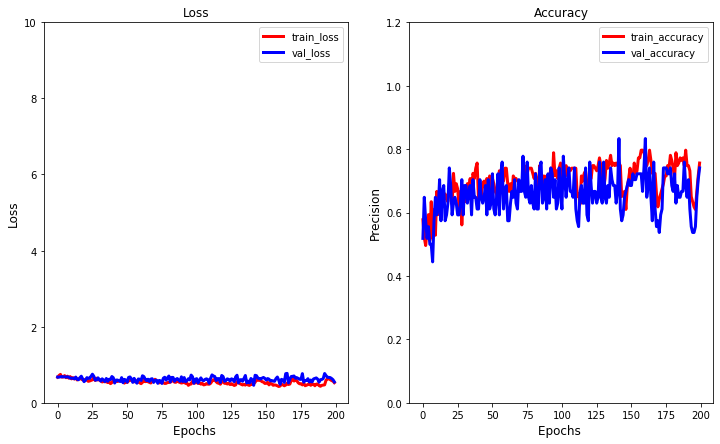

In [101]:
plt.rcParams['figure.figsize'] = [12, 7]

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(history.history['loss'], 'r', linewidth=3.0) 
axs[0].plot(history.history['val_loss'], 'b', linewidth=3.0)
axs[0].legend(['train_loss', 'val_loss'], fontsize=10)
axs[0].set_xlabel('Epochs ', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].set_ylim(0,10)
axs[0].set_title('Loss', fontsize=12)

axs[1].plot(history.history['accuracy'], 'r', linewidth=3.0) 
axs[1].plot(history.history['val_accuracy'], 'b', linewidth=3.0)
axs[1].legend(['train_accuracy', 'val_accuracy'], fontsize=10)
axs[1].set_xlabel('Epochs ', fontsize=12)
axs[1].set_ylabel('Precision', fontsize=12) 
axs[1].set_ylim(0,1.2)
axs[1].set_title('Accuracy', fontsize=12)
plt.show()

# Evaluate the model

In [102]:
from metrics import confusion_matrix

### Training samples

In [103]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_train, y_train_oh)

In [104]:
conf_matrix

array([[57., 25.],
       [ 6., 35.]])

In [105]:
print("Accuracy training: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall training: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion training: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy training: 74.80%
Recall training: 90.48%
Precicion training: 69.51%


### Validation samples

In [106]:
TP, FP, TN, FN, conf_matrix = confusion_matrix(model, X_test, y_test_oh)

In [107]:
conf_matrix

array([[27., 13.],
       [ 1., 13.]])

In [108]:
print("Accuracy testing: %.2f" % ((TP+TN)/(TP+FP+FN+TN)*100) + "%")
print("Recall testing: %.2f" % (TP/(TP+FN)*100) + "%")
print("Precicion testing: %.2f" % (TP/(TP+FP)*100) + "%")

Accuracy testing: 74.07%
Recall testing: 96.43%
Precicion testing: 67.50%
